In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


texts = [
    "What are the top-rated movies?",
    "Find all action movies released in 2020.",
    "Which movies are directed by Christopher Nolan?"
]
queries = [
    "SELECT * FROM movies ORDER BY rating DESC",
    "SELECT * FROM movies WHERE genre='action' AND year=2020",
    "SELECT * FROM movies WHERE director='Christopher Nolan'"
]


tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts + queries)
text_sequences = tokenizer.texts_to_sequences(texts)
query_sequences = tokenizer.texts_to_sequences(queries)


max_length = max(len(seq) for seq in text_sequences)
text_sequences = pad_sequences(text_sequences, maxlen=max_length, padding='post')
query_sequences = pad_sequences(query_sequences, maxlen=max_length, padding='post')


vocab_size = len(tokenizer.word_index) + 1
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=100, input_length=max_length),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(vocab_size, activation='softmax')
])


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model.fit(text_sequences, query_sequences, epochs=10)


def generate_query(text):
    text_sequence = tokenizer.texts_to_sequences([text])
    text_sequence = pad_sequences(text_sequence, maxlen=max_length, padding='post')
    predicted_sequence = model.predict(text_sequence)[0]
    predicted_query = ' '.join([tokenizer.index_word[idx] for idx in tf.argmax(predicted_sequence, axis=-1).numpy()])
    return predicted_query


test_text = "Show me the latest romantic movies."
generated_query = generate_query(test_text)
print("Generated query:", generated_query)


Epoch 1/10


InvalidArgumentError: ignored

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import TFBertModel, BertTokenizer


texts = [
    "What are the top-rated movies?",
    "Find all action movies released in 2020.",
    "Which movies are directed by Christopher Nolan?"
]
queries = [
    "SELECT * FROM movies ORDER BY rating DESC",
    "SELECT * FROM movies WHERE genre='action' AND year=2020",
    "SELECT * FROM movies WHERE director='Christopher Nolan'"
]


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
text_sequences = tokenizer.batch_encode_plus(texts, padding='longest', truncation=True, return_tensors='tf')
query_sequences = tokenizer.batch_encode_plus(queries, padding='longest', truncation=True, return_tensors='tf')


max_length = max(text_sequences['input_ids'].shape[1], query_sequences['input_ids'].shape[1])
text_input_ids = pad_sequences(text_sequences['input_ids'], maxlen=max_length, padding='post')
text_attention_mask = pad_sequences(text_sequences['attention_mask'], maxlen=max_length, padding='post')
query_input_ids = pad_sequences(query_sequences['input_ids'], maxlen=max_length, padding='post')
query_attention_mask = pad_sequences(query_sequences['attention_mask'], maxlen=max_length, padding='post')


bert_model = TFBertModel.from_pretrained('bert-base-uncased')
bert_model.trainable = False

encoder_input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32)
encoder_attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32)
encoder_output = bert_model(encoder_input_ids, attention_mask=encoder_attention_mask)[0]

decoder_input = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32)
decoder_embedding = tf.keras.layers.Embedding(len(tokenizer.get_vocab()), 100)(decoder_input)
decoder_lstm = tf.keras.layers.LSTM(64)(decoder_embedding)
decoder_output = tf.keras.layers.Dense(len(tokenizer.get_vocab()), activation='softmax')(decoder_lstm)

model = tf.keras.models.Model(inputs=[encoder_input_ids, encoder_attention_mask, decoder_input], outputs=decoder_output)


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model.fit(
    [text_input_ids, text_attention_mask, query_input_ids],
    query_input_ids,
    epochs=10,
    batch_size=1
)



def generate_query(text):
    input_ids = tokenizer.encode_plus(text, padding='longest', truncation=True, return_tensors='tf')
    input_ids = pad_sequences(input_ids['input_ids'], maxlen=max_length, padding='post')
    attention_mask = pad_sequences(input_ids['attention_mask'], maxlen=max_length, padding='post')
    predicted_sequence = model.predict([input_ids, attention_mask, input_ids])[0]
    predicted_query = tokenizer.decode(predicted_sequence, skip_special_tokens=True)
    return predicted_query



test_text = "Show me the latest romantic"
generate_query(test_text)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/10


ValueError: ignored

In [ ]:
from transformers import AutoModelWithLMHead, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-wikiSQL")
model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-wikiSQL")

def get_sql(query):
    input_text = "translate English to SQL: %s </s>" % query
    features = tokenizer([input_text], return_tensors='pt')
    output = model.generate(input_ids=features['input_ids'], attention_mask=features['attention_mask'])
    return tokenizer.decode(output)


query = "How many models were finetuned using BERT as base model?"
generated_query = get_sql(query)
print(generated_query)

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


ValueError: ignored

In [ ]:
import torch
from transformers import BertTokenizer, BertForMaskedLM

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased').eval()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def generate_new_query(query, masked_text, num_predictions=5):
    input_ids = tokenizer.encode(masked_text, return_tensors='pt')
    mask_index = torch.where(input_ids == tokenizer.mask_token_id)[1]

    with torch.no_grad():
        outputs = model(input_ids)
        predictions = outputs.logits

    top_tokens = torch.topk(predictions[0, mask_index], num_predictions).indices.tolist()

    generated_queries = []
    for token in top_tokens:
        new_query = masked_text.replace(tokenizer.mask_token, tokenizer.decode([token]))
        generated_queries.append(new_query)

    return generated_queries


In [ ]:
query = "What are the best ways to lose weight?"
masked_text = "What are the [MASK] ways to lose weight?"

generated_queries = generate_new_query(query, masked_text)
print(generated_queries)


TypeError: ignored

In [ ]:
import torch
from torch.utils.data import Dataset
from transformers import BartTokenizer, BartForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer

class TextSQLDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text, sql_query = self.data[idx]
        encoding = self.tokenizer(text, sql_query, truncation=True, max_length=self.max_length, padding='max_length', return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': encoding['labels'].flatten()
        }


In [ ]:
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post4-py3-none-any.whl size=2973 sha256=67037003a8a16e1a563c28c52b296b23ff267bfd210a1387a9d1f5c3ea0e81ad
  Stored in directory: /root/.cache/pip/wheels/46/b8/69/4f7789b7d2fc0718a44cbc4ae5d40970a40c22c472ae50f0a1
Successfully built sklearn


In [ ]:
from sklearn.model_selection import train_test_split


text_list = ["Example text 1", "Example text 2", "Example text 3"]
sql_list = ["SELECT * FROM example_table1", "SELECT * FROM example_table2", "SELECT * FROM example_table3"]

data = list(zip(text_list, sql_list))


train_data, val_data = train_test_split(data, test_size=0.1)


In [ ]:
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

max_length = 128

train_dataset = TextSQLDataset(train_data, tokenizer, max_length)
val_dataset = TextSQLDataset(val_data, tokenizer, max_length)


In [ ]:
import torch
from torch.utils.data import Dataset
from transformers import BartTokenizer, BartForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer

class TextSQLDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text, sql_query = self.data[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, truncation=True, padding='max_length')
        labels_encoding = self.tokenizer(sql_query, return_tensors='pt', max_length=self.max_length, truncation=True, padding='max_length')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': labels_encoding['input_ids'].flatten()
        }


text_list = ["Example text 1", "Example text 2", "Example text 3"]
sql_list = ["SELECT * FROM example_table1", "SELECT * FROM example_table2", "SELECT * FROM example_table3"]

data = list(zip(text_list, sql_list))


train_data, val_data = train_test_split(data, test_size=0.1)

tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
max_length = 128

train_dataset = TextSQLDataset(train_data, tokenizer, max_length)
val_dataset = TextSQLDataset(val_data, tokenizer, max_length)

model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

training_args = Seq2SeqTrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir='./logs',
    logging_steps=10,
    save_steps=100,
    evaluation_strategy='steps',
    save_total_limit=2,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()


Step,Training Loss,Validation Loss


TrainOutput(global_step=3, training_loss=14.86847178141276, metrics={'train_runtime': 21.7242, 'train_samples_per_second': 0.276, 'train_steps_per_second': 0.138, 'total_flos': 457302343680.0, 'train_loss': 14.86847178141276, 'epoch': 3.0})

In [ ]:
model.save_pretrained("fine_tuned_bart")


In [ ]:
def generate_query(text_input, model, tokenizer):
    inputs = tokenizer.encode(text_input, return_tensors='pt', max_length=max_length, truncation=True, padding='max_length')
    outputs = model.generate(inputs, num_beams=5, max_length=max_length, early_stopping=True)
    decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return decoded_output

text_input = "Example input text."
loaded_model = BartForConditionalGeneration.from_pretrained("fine_tuned_bart")
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

query = generate_query(text_input, loaded_model, tokenizer)
print(query)


Example input text.


In [ ]:
import torch
from torch.utils.data import Dataset
from transformers import BartTokenizer, BartForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer

class TextSQLDataset(Dataset):
    def __init__(self, data, tokenizer, max_length):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text, sql_query = self.data[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, truncation=True, padding='max_length')
        labels_encoding = self.tokenizer(sql_query, return_tensors='pt', max_length=self.max_length, truncation=True, padding='max_length')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': labels_encoding['input_ids'].flatten()
        }


text_list = ["Example text 1", "Example text 2", "Example text 3"]
sql_list = ["SELECT * FROM example_table1", "SELECT * FROM example_table2", "SELECT * FROM example_table3"]

data = list(zip(text_list, sql_list))


train_data, val_data = train_test_split(data, test_size=0.1)

tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
max_length = 128

train_dataset = TextSQLDataset(train_data, tokenizer, max_length)
val_dataset = TextSQLDataset(val_data, tokenizer, max_length)

model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

training_args = Seq2SeqTrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir='./logs',
    logging_steps=10,
    save_steps=100,
    evaluation_strategy='steps',
    save_total_limit=2,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()

def generate_query(text_input, model, tokenizer):
    inputs = tokenizer.encode(text_input, return_tensors='pt', max_length=max_length, truncation=True, padding='max_length')
    outputs = model.generate(inputs, num_beams=5, max_length=max_length, early_stopping=True)
    decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return decoded_output

text_input = "Example input text."
loaded_model = BartForConditionalGeneration.from_pretrained("fine_tuned_bart")
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

query = generate_query(text_input, loaded_model, tokenizer)
print(query)


Step,Training Loss,Validation Loss


Example input text.


In [ ]:

text_list = [
    "Get all users from the users table",
    "Get all products from the products table",
    "List all orders in the orders table",
    "Show all employees from the employees table",
    "Find all transactions in the transactions table"
] * 50

sql_list = [
    "SELECT * FROM users",
    "SELECT * FROM products",
    "SELECT * FROM orders",
    "SELECT * FROM employees",
    "SELECT * FROM transactions"
] * 50

data = list(zip(text_list, sql_list))


In [ ]:
train_data, val_data = train_test_split(data, test_size=0.1)

tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')
max_length = 128

train_dataset = TextSQLDataset(train_data, tokenizer, max_length)
val_dataset = TextSQLDataset(val_data, tokenizer, max_length)

model = BartForConditionalGeneration.from_pretrained('facebook/bart-base')

training_args = Seq2SeqTrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir='./logs',
    logging_steps=10,
    save_steps=100,
    evaluation_strategy='steps',
    save_total_limit=2,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()


Step,Training Loss,Validation Loss
10,12.292600,8.704327
20,7.056900,4.474647
30,4.455600,3.141502
40,3.215500,2.157174
50,2.248600,1.328096
60,1.425000,0.708405
70,0.784200,0.327503
80,0.372900,0.135078
90,0.163000,0.053522
100,0.065700,0.021041


Step,Training Loss,Validation Loss
10,12.292600,8.704327
20,7.056900,4.474647
30,4.455600,3.141502
40,3.215500,2.157174
50,2.248600,1.328096
60,1.425000,0.708405
70,0.784200,0.327503
80,0.372900,0.135078
90,0.163000,0.053522
100,0.065700,0.021041


TrainOutput(global_step=290, training_loss=1.1092139679007231, metrics={'train_runtime': 4950.4902, 'train_samples_per_second': 0.455, 'train_steps_per_second': 0.059, 'total_flos': 171488378880000.0, 'train_loss': 1.1092139679007231, 'epoch': 10.0})

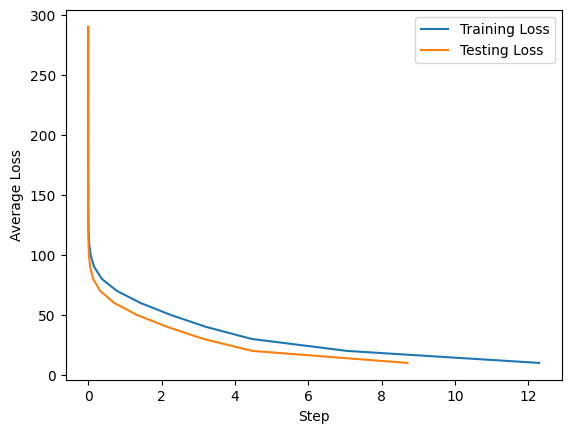

In [ ]:
import matplotlib.pyplot as plt


plt.xlabel("Step")
plt.ylabel("Average Loss")

plt.plot(a, step, label= "Training Loss")
plt.plot(b, step, label="Testing Loss")

plt.legend()
plt.show()

In [ ]:
def generate_query(text_input, model, tokenizer):
    inputs = tokenizer.encode(text_input, return_tensors='pt', max_length=max_length, truncation=True, padding='max_length')
    outputs = model.generate(inputs, num_beams=5, max_length=max_length, early_stopping=True)
    decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return decoded_output

text_input = "List all items in the items table."
loaded_model = BartForConditionalGeneration.from_pretrained("fine_tuned_bart")
tokenizer = BartTokenizer.from_pretrained('facebook/bart-base')

query = generate_query(text_input, loaded_model, tokenizer)
print(query)


List all items in the items table.
